<a href="https://colab.research.google.com/github/tgieruc/Heritage-in-the-digital-age/blob/main/pipeline/notebooks/segmentation_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo of the segmentation model

This is a demo of the class-agnostic segmentation model from the [Heritage in the Digital Age](https://github.com/tgieruc/Heritage-in-the-digital-age) project.

In [1]:
!pip install -q -U --no-cache-dir gdown --pre
!pip install -q segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 19.8 MB/s eta 0:00:00


In [2]:
!wget https://raw.githubusercontent.com/tgieruc/Heritage-in-the-digital-age/main/pipeline/src/segmentation.py
!sed -i 's/\[0\.000, 0\.447, 0\.741\]/\[1, 0, 0\]/g' segmentation.py


--2023-01-09 14:41:11--  https://raw.githubusercontent.com/tgieruc/Heritage-in-the-digital-age/main/pipeline/src/segmentation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16650 (16K) [text/plain]
Saving to: ‘segmentation.py’

segmentation.py     100%[===================>]  16.26K  --.-KB/s    in 0s      

2023-01-09 14:41:11 (42.5 MB/s) - ‘segmentation.py’ saved [16650/16650]



In [3]:
!gdown 1OWH7arM-qllbCJwqkMVy9NKWHB398iol

Downloading...
From: https://drive.google.com/uc?id=1OWH7arM-qllbCJwqkMVy9NKWHB398iol
To: /content/model_segmentation.pth
100% 97.9M/97.9M [00:02<00:00, 37.6MB/s]


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import torch
from skimage.measure import find_contours
from matplotlib.patches import Polygon
from segmentation import SegmentationModel, plot_results, apply_mask

**Let's load a cute image from Wikimedia!**

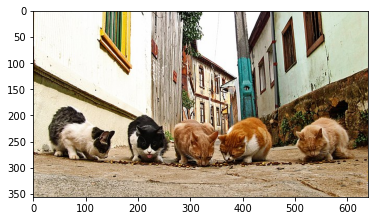

In [5]:
!wget -q https://upload.wikimedia.org/wikipedia/commons/thumb/9/94/Street_cats_%281%29.jpg/640px-Street_cats_%281%29.jpg
filename = '640px-Street_cats_(1).jpg'
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img);

Set the bounding boxes

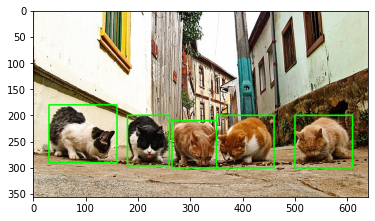

In [8]:
bounding_boxes = torch.tensor([
    [30,  180, 160, 290],
    [180, 200, 260, 296],
    [265, 210, 350, 300],
    [350, 200, 460, 300],
    [500, 200, 610, 300]
]).int()

data_for_segmentation = dict()
data_for_segmentation['bbox'] = bounding_boxes
data_for_segmentation['conf'] = torch.ones(len(bounding_boxes))
data_for_segmentation['labels'] = ['cat'] * len(bounding_boxes)

img_with_bbox = img.copy()
for bounding_box in bounding_boxes.numpy():
  img_with_bbox = cv2.rectangle(img_with_bbox, (bounding_box[0], bounding_box[1]), (bounding_box[2], bounding_box[3]), (0, 255, 0), 2)
plt.imshow(img_with_bbox);

**Initialize the model**

In [9]:
model = SegmentationModel('model_segmentation.pth', device='cuda')

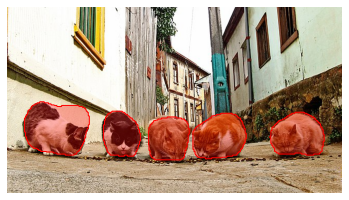

In [10]:
results_deep_color = model.single_inference(img.copy(), data_for_segmentation)
_ = plot_results(img.copy(), data_for_segmentation, expression='cat', ax=plt.gca(), segmentations=results_deep_color)

**It also works with black & white images!**

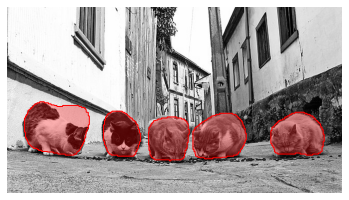

In [11]:
img_bw = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_bw = cv2.cvtColor(img_bw, cv2.COLOR_GRAY2RGB)

results_deep_bw = model.single_inference(img_bw.copy(), data_for_segmentation)
_ = plot_results(img_bw.copy(), data_for_segmentation, expression='cat', ax=plt.gca(), segmentations=results_deep_bw)

**Let's compare with GrabCut!**

In [12]:
def grabcut(img, bounding_boxes):
  for bounding_box in bounding_boxes.numpy():
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (bounding_box[0], bounding_box[1], bounding_box[2] - bounding_box[0], bounding_box[3] - bounding_box[1])
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 1, cv2.GC_INIT_WITH_RECT)
    mask_color = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    img = apply_mask(img, mask_color, [1,0,0], plt.gca())

  plt.imshow(img)
  return img

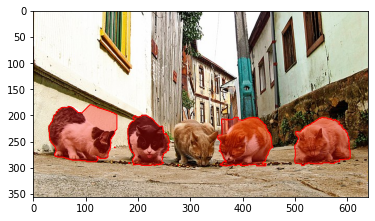

In [13]:
img_color_grabcut = img.copy()
img_color_grabcut = grabcut(img_color_grabcut, bounding_boxes)

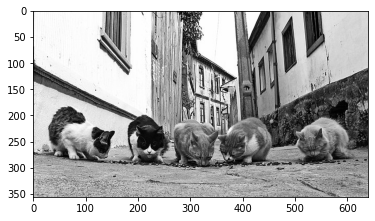

In [14]:
grabcut_bw = img_bw.copy()
grabcut_bw = grabcut(grabcut_bw, bounding_boxes)

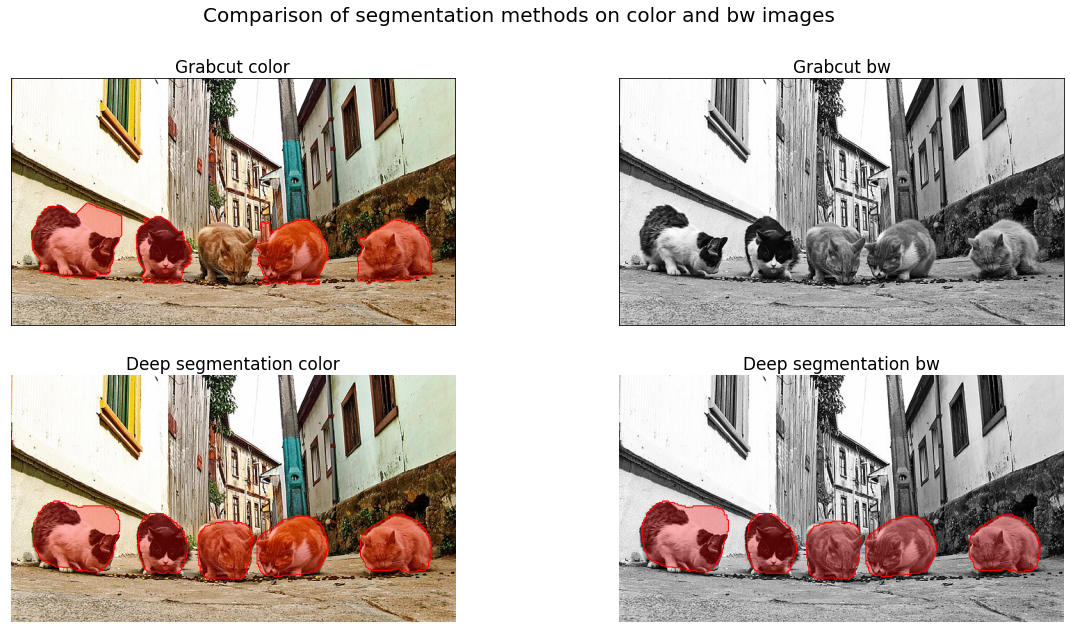

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

img_color_grabcut = img.copy()

for bounding_box in bounding_boxes.numpy():
  mask = np.zeros(img.shape[:2], np.uint8)
  bgdModel = np.zeros((1, 65), np.float64)
  fgdModel = np.zeros((1, 65), np.float64)
  rect = (bounding_box[0], bounding_box[1], bounding_box[2] - bounding_box[0], bounding_box[3] - bounding_box[1])
  cv2.grabCut(img_color_grabcut, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
  mask_color = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
  img_color_grabcut = apply_mask(img_color_grabcut, mask_color, [1, 0, 0], plt.gca())
  padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
  padded_mask[1:-1, 1:-1] = mask_color
  contours = find_contours(padded_mask, 0.5)
  for verts in contours:
      verts = np.fliplr(verts) - 1
      p = Polygon(verts, facecolor="none", edgecolor=[1, 0, 0])
      ax[0,0].add_patch(p)
ax[0,0].imshow(img_color_grabcut)
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,0].set_title('Grabcut color', fontsize=17)

ax[0,1].imshow(grabcut_bw)
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_title('Grabcut bw', fontsize=17)

_ = plot_results(img, data_for_segmentation, ax=ax[1,0], expression='cat', segmentations=results_deep_color)
ax[1,0].set_title('Deep segmentation color', fontsize=17)
ax[1,1].clear()
_ = plot_results(img_bw, data_for_segmentation, ax=ax[1,1], expression='cat', segmentations=results_deep_bw)
ax[1,1].set_title('Deep segmentation bw', fontsize=17)
fig.patch.set_facecolor('xkcd:white')
plt.suptitle('Comparison of segmentation methods on color and bw images', fontsize=20);

**Let's compare inference time** (takes approx. 3 minutes)

143 ms ± 25.8 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


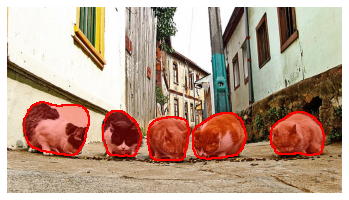

In [16]:
%%timeit -r 10 -n 10
results_deep_color = model.single_inference(img.copy(), data_for_segmentation)
_ = plot_results(img.copy(), data_for_segmentation, expression='cat', ax=plt.gca(), segmentations=results_deep_color)

1.24 s ± 50.7 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


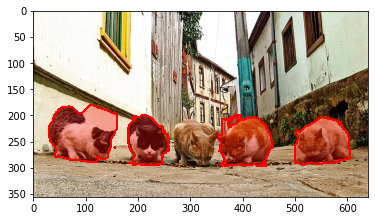

In [17]:
%%timeit -r 10 -n 10
img_color_grabcut = img.copy()
img_color_grabcut = grabcut(img_color_grabcut, bounding_boxes)

**Not only the deep learning segmentation model is up to eleven time faster than GrabCut, but it also gives better results. In color images, its segmentations are slightly better. In Black & White images, GrabCut doesn't succeed to perform segmentation whereas our model performs as good as on a RGB image.**